In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy
import pickle

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%time
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'surf_units': u.micron,
             'ring_width': 3,
             'diam_ca100': 0.05*u.m, #50*u.mm,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m, #1/u.mm,
             'label':'2in'}

nt_ptt = 3
psd_folder = 'zygo_data/flat_mirrors/mvls_psd/'

# open the file
fileloc = 'lspsd_fm_{0}_avg_z{1}.fits'.format(opt_parms['label'], nt_ptt)
psd_fits = fits.open(psd_folder+fileloc)[0]
psd_avg = psd_fits.data * (u.nm*u.m)**2
psd_hdr = psd_fits.header
opt_parms['dk'] = psd_hdr['delta_k']/u.m
opt_parms['diam_ca'] = psd_hdr['diam_ca']*u.m
opt_parms['diam_pix'] = psd_hdr['diam_pix']
opt_parms['wavelen'] = psd_hdr['wavelen'] * u.m

# calculate the radial PSD data
avg_psd = psd.surfPSD(surf_name='average PSD')
avg_psd.load_psd(psd_data=psd_avg, psd_type='cal')
avg_psd.load_psd_parameters(diam_ca=opt_parms['diam_ca'], npix_diam=opt_parms['diam_pix'],
                            wavelen=opt_parms['wavelen'], delta_k=opt_parms['dk'])
avg_psd.calc_psd_radial(ring_width=opt_parms['ring_width'])
avg_psd.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'],
                     pwr_opt=avg_psd.psd_cal, print_rms=False, print_kloc=False)

CPU times: user 253 ms, sys: 12.3 ms, total: 265 ms
Wall time: 269 ms


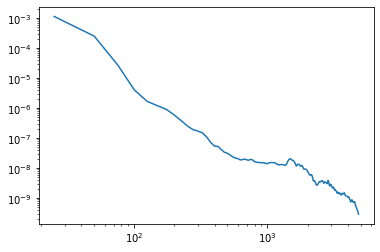

In [3]:
# Throw away some of the high-k ending data for better fitting
# The last data doesn't seem critical anyways
fin = len(avg_psd.k_radial)
offset = 30 # if you change this number, you must re-run above code.
avg_psd.k_radial = avg_psd.k_radial[0:fin-offset]
avg_psd.psd_radial_cal = avg_psd.psd_radial_cal[0:fin-offset]
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value)

In [4]:
%%time
ist = [0, 4, 25]#, 55]
iend = [ist[1], ist[2], len(avg_psd.k_radial)-15]
rms_sr = [0.00005*u.nm, 0.00005*u.nm, 0.08*u.nm]
psd_weight = [1.0, 1.0, 1.0]
k_limit = [np.amin(avg_psd.k_radial)/10, np.amax(avg_psd.k_radial)*10]
surf_unit = (avg_psd.psd_radial_cal.unit * (avg_psd.k_radial.unit**2))**(0.5)
mdl_set = []
x0 = [[1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5],
      [1.0e-3, 1.0e-3, 1.0e-5, 1.0e-6],
      [1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5]]
for j in range(0, len(ist)):
    mdl = psd.model_single(region_num=j)
    mdl.load_data(ind_range=[ist[j],iend[j]], psd_obj=avg_psd)
    mdl.calc_psd_parm(rms_sr=rms_sr[j], x0=x0[j])#, ratio_mode=False)
    mdl.calc_model_total(psd_weight=psd_weight[j], k_spacing=opt_parms['dk']*0.2, k_limit=k_limit)
    mdl_set.append(mdl)

# model sum with a total refit
ms_refit = psd.model_combine(mdl_set=mdl_set, avg_psd=avg_psd)
ms_refit.calc_refit()
ms_refit.calc_error()
ms_refit.calc_psd_rms()

CPU times: user 2.45 s, sys: 31.3 ms, total: 2.48 s
Wall time: 1.29 s


/home/jhen/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


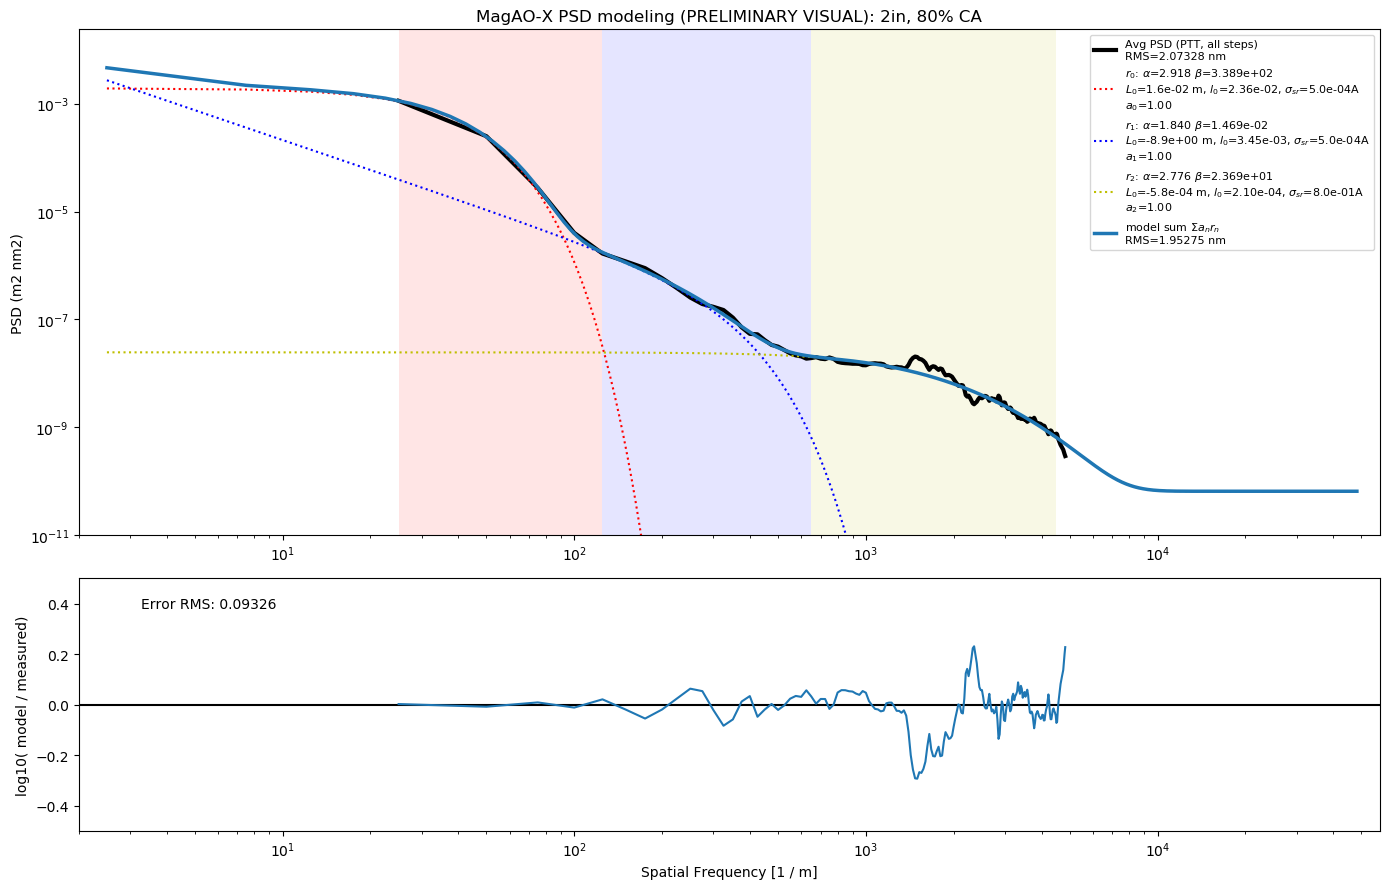

In [5]:
psd.plot_model2(mdl_set, ms_refit, avg_psd, opt_parms)

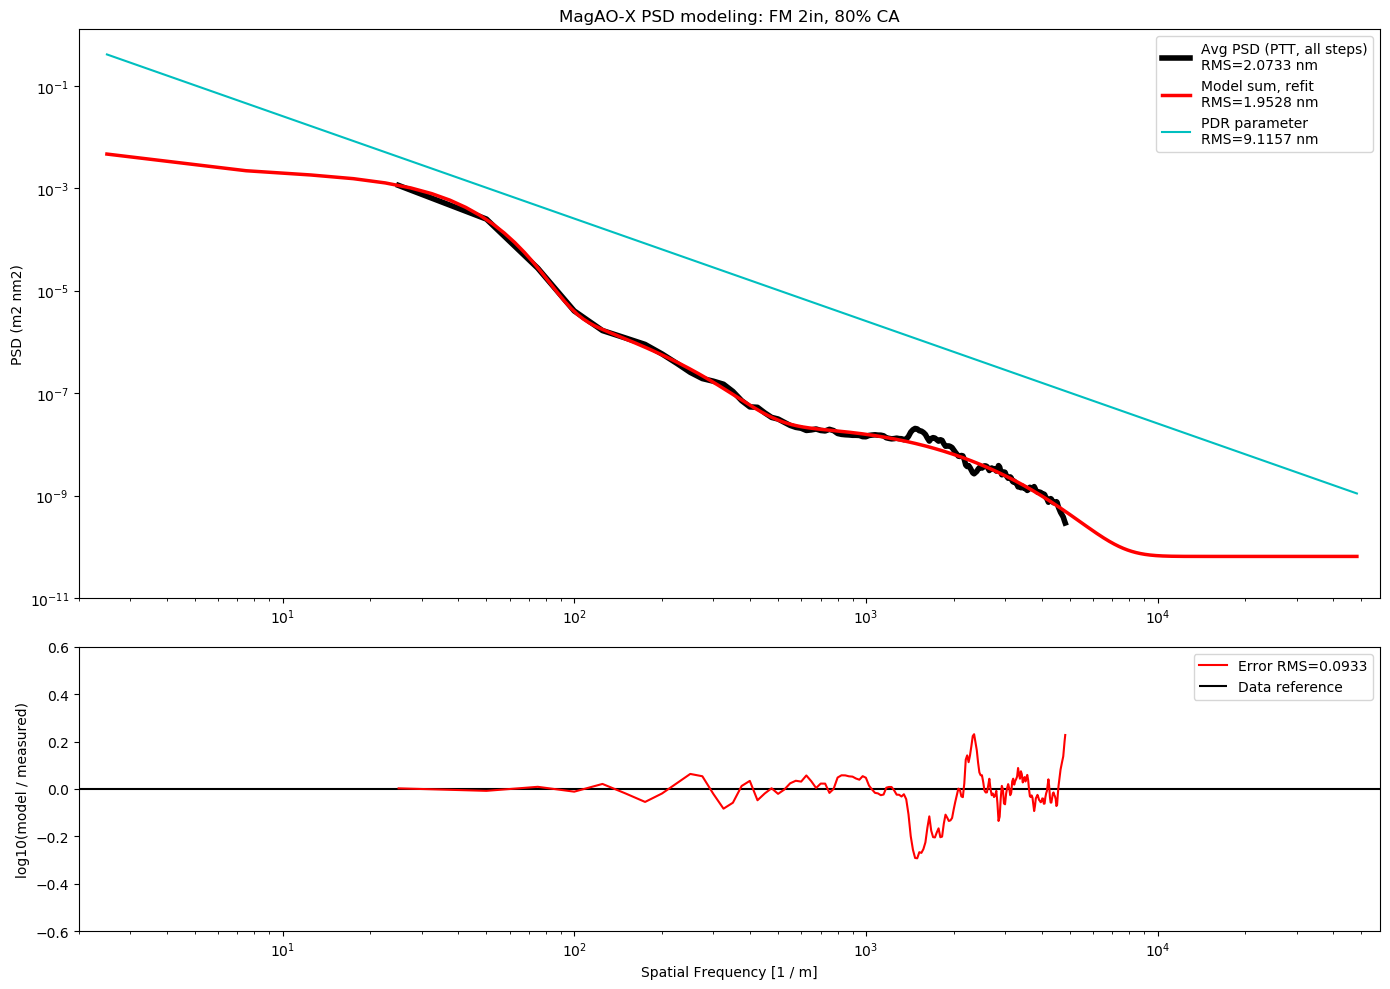

In [9]:
ap = 2.0
bp = 2.55 * (u.nm**2)
parm_pdr = [ap, bp, 0.0*u.m, 0.0, 0*(u.nm*u.m)**2]
psd_pdr = psd.model_full(k=mdl_set[0].k_range, psd_parm=parm_pdr)
pdr_weight = [1.0]

pdr_rms = psd.calc_model_rms(psd_parm=[parm_pdr], psd_weight=pdr_weight, 
                             npix_diam=ms_refit.npix_diam, delta_k=ms_refit.delta_k,
                             k_tgt_lim=[ms_refit.k_min, ms_refit.k_max])

k_radial = avg_psd.k_radial.value
psd_radial = avg_psd.psd_radial_cal.value
k_range_mdl = mdl_set[0].k_range.value

plt.figure(figsize=[14,10],dpi=100)
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4,2])
ax0 = plt.subplot(gs[0])  
ax0.loglog(k_radial, psd_radial, 'k', linewidth=4, label='Avg PSD (PTT, all steps)\nRMS={0:.4f}'.format(avg_psd.rms_tot))
ax0.loglog(k_range_mdl, ms_refit.psd_radial_sum.value, 'r', linewidth=2.5, label='Model sum, refit\nRMS={0:.4f}'.format(ms_refit.psd_rms_sum))
ax0.loglog(k_range_mdl, psd_pdr.value, 'c', linewidth=1.5, label='PDR parameter\nRMS={0:.4f}'.format(pdr_rms))
ax0.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax0.set_ylim(bottom=1e-11)
ax0.set_ylabel('PSD ({0})'.format(ms_refit.psd_radial_sum.unit))
ax0.legend(prop={'size':10})#,loc='center left', bbox_to_anchor=(1, 0.5))
ax0.set_title('MagAO-X PSD modeling: FM 2in, {0}% CA'.format(opt_parms['ca']))

ax1 = plt.subplot(gs[1])
ax1.hlines(y=0, xmin=np.amin(k_range_mdl)*0.8, xmax=np.amax(k_range_mdl)*1.2, color='k', label='Data reference')
ax1.semilogx(k_radial, ms_refit.error, 'r', label='Error RMS={0:.4f}'.format(ms_refit.error_rms))
ax1.legend(prop={'size':10})
ax1.set_ylim(top=0.6, bottom=-0.6)
ax1.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax1.set_ylabel('log10(model / measured)')
ax1.set_xlabel('Spatial Frequency [{0}]'.format(ms_refit.k_radial_data.unit))

plt.tight_layout()

In [6]:
# Save the PSD values into a pickle to access later
psd_dict = {'psd_fm2in': ms_refit.psd_parm,
            'psd_fm2in_weight': psd_weight,
            'psd_fm2in_rms': avg_psd.rms_tot}

# save the directory as a pickle
import pickle
filename='/home/jhen/XWCL/code/MagAOX/PSD/model_parameters/psd_parms_fm{0}.pickle'.format(opt_parms['label'])
with open(filename,'wb') as psd_parameter_file:
    pickle.dump(psd_dict, psd_parameter_file, protocol=4)

In [7]:
# test the pickle
objects = []
with (open(filename, "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
            
objects

[{'psd_fm2in': [[2.9175741702393543,
    <Quantity 338.90864607 nm2 / m(0.9175741702393543)>,
    <Quantity 0.01593319 m>,
    0.023605902249203788,
    <Quantity 2.52855864e-17 m2 nm2>],
   [1.8402090887501832,
    <Quantity 0.01469207 m(0.1597909112498168) nm2>,
    <Quantity -8.86745332 m>,
    0.003452503592691719,
    <Quantity 2.52855864e-17 m2 nm2>],
   [2.7763209213106017,
    <Quantity 23.69279761 nm2 / m(0.7763209213106017)>,
    <Quantity -0.00057902 m>,
    0.00021003054244394682,
    <Quantity 6.47311013e-11 m2 nm2>]],
  'psd_fm2in_weight': [1.0, 1.0, 1.0],
  'psd_fm2in_rms': <Quantity 2.07327677 nm>}]